### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level. Before you go:
* If you haven't done seminar already, use `seminar.ipynb` to download the data.
* This homework uses Pytorch v1.x: this is [how you install it](https://pytorch.org/get-started/locally/); and that's [how you use it](https://github.com/yandexdataschool/Practical_RL/tree/9f89e98d7df7ad47f5d6c85a70a38283e06be16a/week04_%5Brecap%5D_deep_learning).

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [46]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

In [47]:
lines[:3]

[' Dual Recurrent Attention Units for Visual Question Answering ; We propose an architecture for VQA which utilizes recurrent layers to generate visual and textual attention. The memory characteristic of the proposed recurrent attention units offers a rich joint embedding of visual and textual features and enables the model to reason relations between several parts of the image and question. Our single model outperforms the first place winner on the VQA 1.0 dataset, performs within margin to the current state-\n',
 ' Sequential Short-Text Classification with Recurrent and Convolutional   Neural Networks ; Recent approaches based on artificial neural networks (ANNs) have shown promising results for short-text classification. However, many short texts occur in sequences (e.g., sentences in a document or utterances in a dialog), and most existing ANN-based systems do not leverage the preceding short texts when classifying a subsequent one. In this work, we present a model based on recurre

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [48]:
# get all unique characters from lines (including capital letters and symbols)
token_set = set()
list(map(lambda x: token_set.update(x), [list(line) for line in lines])) # add list to eager execution
tokens = list(token_set)


In [49]:
tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with it's index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [50]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {token:i for i, token in enumerate(tokens)}

In [51]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integet matrix `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra _EOS_ or cropping long sequences. Here's how it works:

In [52]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [53]:
#Example: cast 4 random names to matrices, pad with zeros
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))



[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model (2 points including training)

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [55]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        """ 
        A fixed window model that looks on at least 5 previous symbols.
        
        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        
        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        # YOUR CODE - create layers/variables and any metadata you want, e.g. self.emb = L.Embedding(...)
        
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.padding = nn.ZeroPad2d((0, 0, 4, 0))
        self.kernel_size = 5
        self.conv = nn.Conv1d(emb_size, hid_size, self.kernel_size)
        self.fc = nn.Linear(hid_size, n_tokens)
        
        #END OF YOUR CODE
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
            
        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        # YOUR CODE - apply layers, see docstring above
        x = self.emb(input_ix)
        x = self.padding(x)
        x = x.permute(0, 2, 1)

        x_conv = self.conv(x)
        # x_conv = F.relu(x_conv)
        x_conv = x_conv.permute(0, 2, 1)
        
        x = self.fc(x_conv)
        
        return x # output tensor should be of shape [batch_size, sequence_length, n_tokens]
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [56]:
dummy_model = FixedWindowLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('emb.weight', 'conv.weight', 'conv.bias', 'fc.weight', 'fc.bias')


In [57]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [58]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [59]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    cumsum = torch.cumsum(input_ix == eos_ix, dim=-1)
    # print('cumsum', cumsum)
    # print(cumsum[..., :-1] < 1)
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)
    # return cumsum[..., :-1] < 1

print('matrix:\n', dummy_input_ix.numpy())
print('mask:\n', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask:
 [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [60]:
def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64)
    

    logits = model(input_ix[:, :-1])
    # logits = F.log_softmax(logits, dim=2)
    # print(f'logits.shape: {logits.shape}')
    reference_answers = input_ix[:, 1:]

    # Your task: implement loss function as per formula above
    # your loss should only be computed on actual tokens, excluding padding
    # predicting actual tokens and first EOS do count. Subsequent EOS-es don't
    # you may or may not want to use the compute_mask function from above.
    
    # input_mask = compute_mask(input_ix[:, :-1])
    input_mask = compute_mask(reference_answers)
    input_mask = torch.unsqueeze(input_mask, 2)
    # print('input_mask.shape:', input_mask.shape)
    # print('logits[0]:', logits[0])
    masked_logits = torch.mul(logits, input_mask) # 对应位相乘
    masked_logits = F.log_softmax(masked_logits, dim=2)
    # print(f'masked_logits.shape: {masked_logits.shape}')
    # celoss = nn.CrossEntropyLoss()
    # loss = celoss(masked_logits, reference_answers)
    # print(f'masked_logits.shape: {masked_logits.shape}')
    # print('reference_answers.shape, ', reference_answers.shape)
    ml = masked_logits.reshape(-1, masked_logits.size(2))
    ref = reference_answers.reshape(-1)
    # print(ref)
    loss = F.cross_entropy(ml, ref) / len(input_ix)
    # print(loss.shape)

    return loss
    

In [61]:
input = to_matrix(dummy_lines, max_len=15)
print('input shape', input.shape)
loss_1 = compute_loss(dummy_model, input)
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
print(loss_1, loss_2)

input shape (3, 15)
tensor(1.6738, grad_fn=<DivBackward0>) tensor(1.6714, grad_fn=<DivBackward0>)


In [62]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

AssertionError: do not include  AFTER first EOS into loss. Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!

### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [ ]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [ ]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
model = FixedWindowLanguageModel()
opt = torch.optim.Adam(model.parameters())

# hint: if you ever wanted to switch to cuda, do it now.

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: BridgingGpàś@ε84ü'b'oσ!õ?ôWÉáωhŁρν{ÉAã~W/è8FQ&=w(ν%\WjáôO0éAβö lo%qMgJα<8RE|O#4Vucõsgü=MüeLα6/q-qklCE


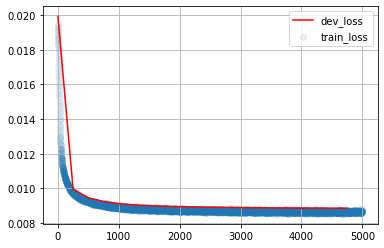

Generated examples (tau=0.5):
 Lares ; The lesscal tesestraction ded en works ge che and the probe core res monting and thation for
 of the ing al angenges on thme tha n aral oful tove and bere frestive fo montor armentice of reatl a
 A Monting of thain the ter and and and co pledention the s aromation ; Whe the the the roproce probl
Scoring dev...


100%|██████████| 5000/5000 [47:55<00:00,  1.74it/s]

#4999 Dev loss: 0.009


In [ ]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    
    loss_i = compute_loss(model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
        
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 0.008852234311220123
 Foress the trobles and cons as andse finasion thation late for as the ang arner andec ination thing 
 Ne whe s and se work serecentigo s ale tion are the des an ing and with al he whe the the s an thar 
 Ad pores mantion the prodeat des of amplesentitit  formation lation of the s aletrom ation as inged 
 Scoproblem io preatival oral and tha deation thed the requede the sentren s anderating is wors and t
 Nesion dal and ale and bee verel cende mode  abetion the re pores machint on the probes the the the 
 Aderens the s apporeas aralization the sens de thmention aring an objective the se s for andition th
 A peration d aund araly thow ing arel cod extive rechis pacel mation late the he se the cons in tho 
 Araplearne and the the pesertint at of ars aralize toves ; This and the ins ate the serevere tores t
 Faris and works mation that on the pares. The tho se whed er be der and and sed pe poralis and the p
 Os ane Experache ron seathec int on or alsic

### RNN Language Models (3 points including training)

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [ ]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        
        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        # YOUR CODE - create layers/variables/etc
        
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=hid_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hid_size, n_tokens)
        #END OF YOUR CODE
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        # YOUR CODE - apply layers, see docstring above
        x = self.emb(input_ix)
        x_lstm, (h_n, c_n) = self.lstm(x)
        x_fc = self.fc(x_lstm)
        return x_fc # output tensor should be of shape [batch_size, sequence_length, n_tokens]
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [ ]:
model = RNNLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('emb.weight', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'fc.weight', 'fc.bias')


In [ ]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [ ]:
batch_size = 64         # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 250
train_history, dev_history = [], []

model = RNNLanguageModel(n_tokens=136)
opt = torch.optim.Adam(model.parameters())

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridgingv#,`ã°



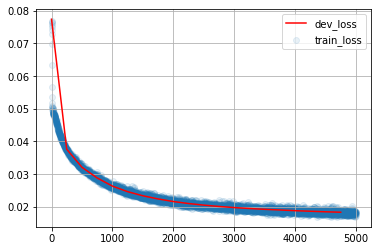

Generated examples (tau=0.5):
 Multi-and Discovery of Quantize Large Runk dependencies for a compute the state of the inverse produ
 Generalized Selection ; In this paper we propose an important and the structured and segmentation is
 Semantic Segmentation for Modern Patch Matching ; Recent we are being the training a new approach to
Scoring dev...


100%|██████████| 5000/5000 [2:43:30<00:00,  1.96s/it]

#4999 Dev loss: 0.018


In [ ]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    # <YOUR CODE - one step of the training loop for your RNN model>
    opt.zero_grad()    
    loss_i = compute_loss(model, batch)
    loss_i.backward()
    nn.utils.clip_grad.clip_grad_value_(model.parameters(), 0.5)
    opt.step()

    train_history.append((i, float(loss_i)))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 0.018180988125684784
 Learning to Determination on Model Herning for Non-Low-Rank Neural Networks ; We present a multi-ana
 An Event Sensing Approach for Image Convolutional Neural Networks ; Deep neural network to formaliza
 A New Sparse Segmentation ; The algorithm in the parameter and complete theoretical static constrain
 Neural Networks for deep Learning ; The problem of community to a control based on strategy of the a
 Structural Optimization and Experimental Learning ; We show to relate and important to some of the g
 A Bayesian networks and Proposed Learning ; In this paper, we propose a new approach to statisticall
 Real-Time Selection (LSTM) method for interest containing an algorithm for Recurrent Neural Networks
 Deep Learning for Measure for Streams ; The proposed approach to a generation of the same and explan
 Recurrent Neural Networks for Construction Sensing ; The network models for complex the statistical 
 Link Convolutional Neural Networks for Monte

### Alternative sampling strategies (1 point)

So far we've sampled tokens from the model in proportion with their probability.
However, this approach can sometimes generate nonsense words due to the fact that softmax probabilities of these words are never exactly zero. This issue can be somewhat mitigated with sampling temperature, but low temperature harms sampling diversity. Can we remove the nonsense words without sacrificing diversity? __Yes, we can!__ But it takes a different sampling strategy.

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize: 
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleous sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleous N=0.9, the nucleous words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleous words, you need to re-normalize them as in top-k sampling and generate the next token.

__Your task__ is to implement nucleus sampling variant and see if its any good.

In [ ]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    """
    Generate a sequence with nucleous sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix
    
    :note: make sure that nucleous always contains at least one word, even if p(w*) > nucleus
    
    """
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        tokens, probs = zip(*sorted(token_probs.items(), key=lambda x: x[1], reverse=True))
        probs = list(probs)
        prob_sum = 0
        max_idx = 0
        for i in range(len(probs)):
            prob_sum += probs[i]
            if prob_sum > nucleus:
                max_idx = i
                break
        for j in range(max_idx + 1, len(probs)): probs[j] = 0
        norm = np.sum(probs)
        probs = [p/norm for p in probs]
        next_token = np.random.choice(tokens, p=probs)
        
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [ ]:
for i in range(10):
    print(generate_nucleus(model))

 Point of Multi-Reguling Optimization Based Graph ; A Classification algorithms in the properties of 
 The Variational Face Mutation Assessment of Bayesian Action Approach to Cameras ; We introduce the S
 A Huper Analysis of Image Recognition in Latent Deformation of Results ; This paper and sensing a mu
 Interest-based Design Scenario Towards Based Reported Matrix Fully Neural Network for Find Combinano
 Shary Detection Images Makes with Distribution in Erguine Mutual Generative Models ; We introduce th
 Regression with Matagative Field consistency for   for a specific tracking ; As the results with sou
 For a Task   Emploted Via Geometry Activation ; In this paper, we exploit consist loss in the experi
 Segmentation in Challenging Usel Level Independent Learning ; This paper is to estimate the research
 A New Extraction ; Deconvolutions and often unknowledges in so not approaches. The end-to-end first 
 Multi-Form in Interpretability of Estimation ; Computer vision problem by solutio

### Bonus quest I: Beam Search (2 pts incl. samples)

At times, you don't really want the model to generate diverse outputs as much as you want a __single most likely hypothesis.__ A single best translation, most likely continuation of the search query given prefix, etc. Except, you can't get it. 

In order to find the exact most likely sequence containing 10 tokens, you would need to enumerate all $|V|^{10}$ possible hypotheses. In practice, 9 times out of 10 you will instead find an approximate most likely output using __beam search__.

Here's how it works:
0. Initial `beam` = [prefix], max beam_size = k
1. for T steps:
2. ` ... ` generate all possible next tokens for all hypotheses in beam, formulate `len(beam) * len(vocab)` candidates
3. ` ... ` select beam_size best for all candidates as new `beam`
4. Select best hypothesis (-es?) from beam

In [ ]:
from IPython.display import HTML
# Here's what it looks like:
!wget -q https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/resources/beam_search.html
HTML("beam_search.html")

In [81]:
def generate_beamsearch(model, prefix=BOS, beam_size=4, length=5):
    """
    Generate a sequence with nucleous sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param length: generate sequences with at most this many tokens, NOT INCLUDING PREFIX
    :returns: beam_size most likely candidates
    :note: make sure that nucleous always contains at least one word, even if p(w*) > nucleus
    """
    
    # <YOUR CODE HERE>
    sequence_prob = []
    for i in range(length):
        if len(sequence_prob) == 0:
            token_probs = model.get_possible_next_tokens(prefix)
            token_probs = sorted(token_probs.items(), key=lambda x: x[1], reverse=True)
            sequence_prob = [(token, np.log(prob)) for token, prob in token_probs[:beam_size]]
        else:
            sequence_prob_new = []
            for tok, log_prob in sequence_prob:
                prefix_new = prefix + tok
                # print(f'prefix: {prefix_new}')
                token_probs = model.get_possible_next_tokens(prefix_new)
                token_probs = sorted(token_probs.items(), key=lambda x: x[1], reverse=True)
                sequence_prob_new += [(tok +token, log_prob + np.log(prob)) for token, prob in token_probs[:beam_size]]
                # print(f'sequence_prob_new: {sequence_prob_new}')
            sequence_prob = sorted(sequence_prob_new, key=lambda x: x[1], reverse=True)[:beam_size]
        print(f'at time {i}, sequence_prob: {sequence_prob}')
        ...
    
    sequence_prob.sort(key=lambda x: x[1], reverse=True)
    return sequence_prob[0][0]
    

In [72]:
generate_nucleus(model, prefix=' deep ', max_len=10)

' deep and s'

In [87]:
generate_beamsearch(model, prefix=' deep ', beam_size=10)

at time 0, sequence_prob: [('l', -1.5068771), ('n', -1.8065959), ('L', -2.6358395), ('N', -2.8169146), ('c', -2.9389367), ('a', -3.3885388), (' ', -3.416483), ('C', -3.5385532), ('R', -3.5742204), ('e', -3.672916)]
at time 1, sequence_prob: [('le', -1.5643963), ('ne', -1.8384411), ('Le', -2.836633), ('Ne', -2.8548415), ('co', -3.2234898), ('  ', -3.5252151), ('Re', -3.7488828), ('Co', -4.04846), ('an', -4.1490107), ('en', -4.306381)]
at time 2, sequence_prob: [('lea', -1.6008773), ('neu', -2.1250048), ('Lea', -2.9126318), ('Neu', -3.0605521), ('con', -3.4188592), ('net', -3.4200287), ('Con', -4.4806757), ('and', -4.520799), ('Rec', -4.668638), ('Net', -4.732559)]
at time 3, sequence_prob: [('lear', -1.6240636), ('neur', -2.1312099), ('Lear', -2.9528904), ('Neur', -3.0653412), ('netw', -3.4399335), ('conv', -4.4241753), ('and ', -4.534765), ('cons', -4.6973867), ('Netw', -4.773192), ('Conv', -4.849742)]
at time 4, sequence_prob: [('learn', -1.6297319), ('neura', -2.1763425), ('Learn', -

'learn'

In [74]:
# check it out: which beam size works best?
# find at least 5 prefixes where beam_size=1 and 8 generates different sequences

### Bonus quest II: Ultimate Language Model (2+ pts)

So you've learned the building blocks of neural language models, you can now build the ultimate monster:  
* Make it char-level, word level or maybe use sub-word units like [bpe](https://github.com/rsennrich/subword-nmt);
* Combine convolutions, recurrent cells, pre-trained embeddings and all the black magic deep learning has to offer;
  * Use strides to get larger window size quickly. Here's a [scheme](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif) from google wavenet.
* Train on large data. Like... really large. Try [1 Billion Words](http://www.statmt.org/lm-benchmark/1-billion-word-language-modeling-benchmark-r13output.tar.gz) benchmark;
* Use training schedules to speed up training. Start with small length and increase over time; Take a look at [one cycle](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for learning rate;

_You are NOT required to submit this assignment. Please make sure you don't miss your deadline because of it :)_